In [2]:
# Import math and statistics libraries
import numpy as np

# Import data manipulation libraries
import pandas as pd

# Import graphing libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import system libraries
import os
from dotenv import load_dotenv

# Import Polygon.io client for financial data
from polygon import RESTClient

# import sys
# sys.path.append(os.path.abspath(os.path.join('..', 'src')))
# from polygon_api import PolygonAPI

In [3]:
# Get the API key from environment variables
load_dotenv()
api_key = os.getenv('POLYGON_API_KEY')

In [4]:
# Tickers from a selection of the S&P 500 companies
tickers = ['AAPL', 'MSFT', 'GOOGL', 'IBM', 'AMZN', 'NVDA',
          'XOM', 'CVX', 'WMT', 'MMM', 'ARE', 'ALLE', 'JPM',
          'V', 'MA', 'PEP', 'CSCO', 'BA', 'ADBE', 'CAT', 
          'BLK', 'INTC', 'NKE', 'MDLZ']

In [5]:
import subprocess

def get_root_path():
    """Get the root path of the git repository."""

    try:
        # Check if the current directory is a git repository
        repo_path = subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).decode().strip()
        return repo_path
    except subprocess.CalledProcessError:
        return None

repo_path = get_root_path()


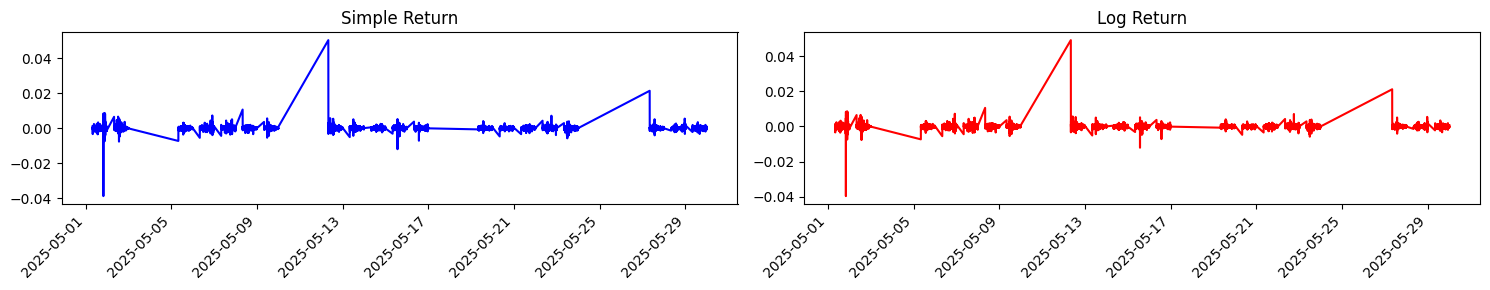

Simple Return: 0.00049 %
Log Return: 0.00044 %


In [6]:
source_path = repo_path + "/data/polygon/intraday/amzn/"

amzn = pd.read_parquet(source_path)
amzn.sort_index(inplace=True)

amzn['simple_return'] = (amzn['close'] / amzn['close'].shift(1)) - 1
amzn['log_return'] = np.log(amzn['close'] / amzn['close'].shift(1))

fig, axes = plt.subplots(1, 2, figsize=(15, 3), sharex=True)
amzn['simple_return'].plot(ax=axes[0], title='Simple Return', color='blue')
amzn['log_return'].plot(ax=axes[1], title='Log Return', color='red')

for ax in axes:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

print(f"Simple Return: {round(amzn['simple_return'].mean() * 100, 5)} %")
print(f"Log Return: {round(amzn['log_return'].mean() * 100, 5)} %")

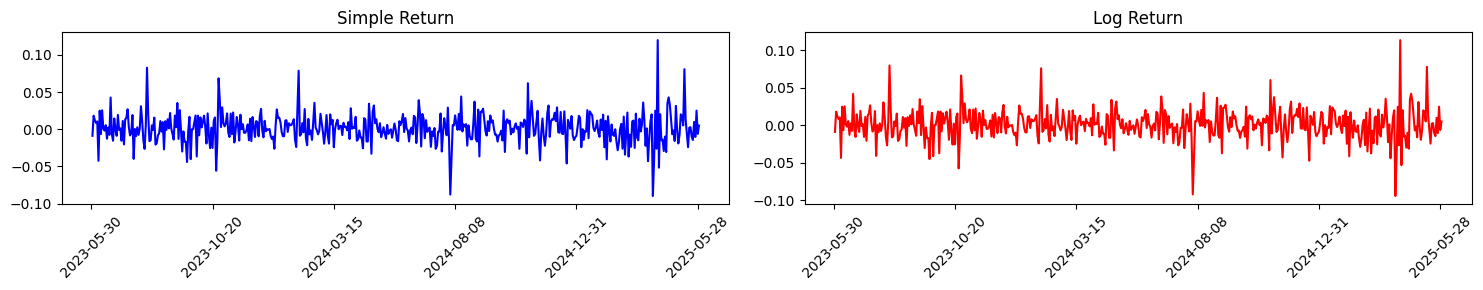

Simple Return: 0.12452 %
Log Return: 0.10483 %


In [7]:
source_path = repo_path + "/data/polygon/daily/amzn/"

amzn_daily = pd.read_parquet(source_path)
amzn_daily.index = pd.to_datetime(amzn_daily.index).strftime('%Y-%m-%d')
amzn_daily.sort_index(inplace=True)

amzn_daily['simple_return'] = (amzn_daily['close'] / amzn_daily['close'].shift(1)) - 1
amzn_daily['log_return'] = np.log(amzn_daily['close'] / amzn_daily['close'].shift(1))

fig, axes = plt.subplots(1, 2, figsize=(15, 3), sharex=True)
amzn_daily['simple_return'].plot(ax=axes[0], title='Simple Return', color='blue')
amzn_daily['log_return'].plot(ax=axes[1], title='Log Return', color='red')

for ax in axes:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

print(f"Simple Return: {round(amzn_daily['simple_return'].mean() * 100, 5)} %")
print(f"Log Return: {round(amzn_daily['log_return'].mean() * 100, 5)} %")

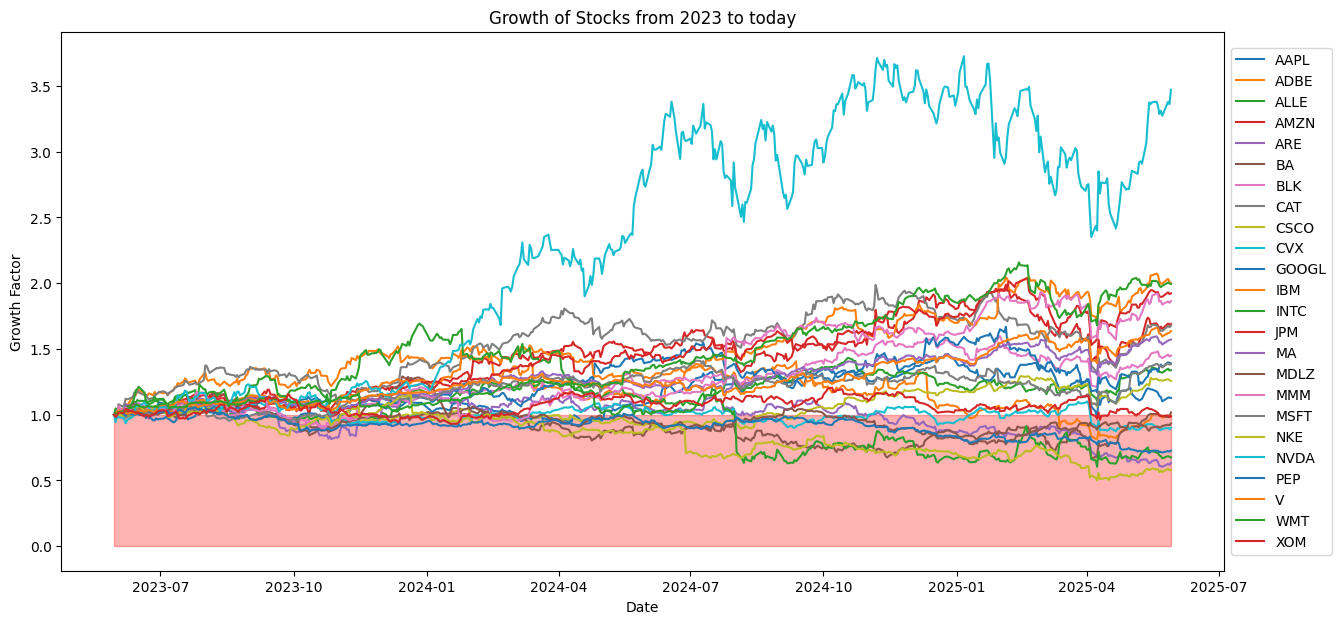

In [8]:
source_daily_path = repo_path + "/data/polygon/daily/"


df = pd.DataFrame()
simple_returns = pd.DataFrame()

plt.figure(figsize=(15, 7))

for ticker in os.listdir(source_daily_path):
    df[ticker] = pd.read_parquet(source_daily_path + ticker + "/")['close']
    simple_returns[ticker] = (df[ticker] / df[ticker].shift(1)) - 1
    growth = (df[ticker] / df[ticker].iloc[0])
    plt.plot(df.index, growth, label=ticker.upper())

thres = 1.0

plt.fill_between(df.index, thres, 0, where=(df[ticker] > thres), color='red', alpha=0.3)
plt.title('Growth of Stocks from 2023 to today')
plt.xlabel('Date')
plt.ylabel('Growth Factor')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

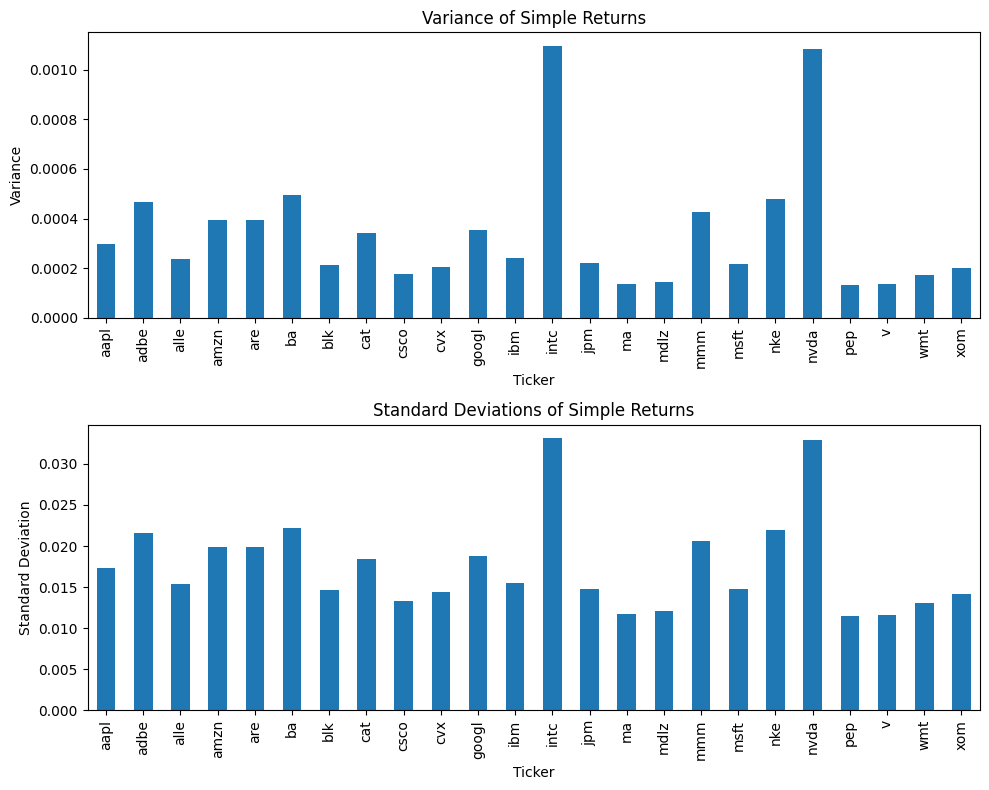

In [9]:
# Create a figure and two subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot variance of returns
simple_returns.var().plot(kind='bar', ax=axs[0], title='Variance of Simple Returns')
axs[0].set_xlabel('Ticker')
axs[0].set_ylabel('Variance')

# Plot standard deviation of returns
simple_returns.std().plot(kind='bar', ax=axs[1], title='Standard Deviations of Simple Returns')
axs[1].set_xlabel('Ticker')
axs[1].set_ylabel('Standard Deviation')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


<Axes: >

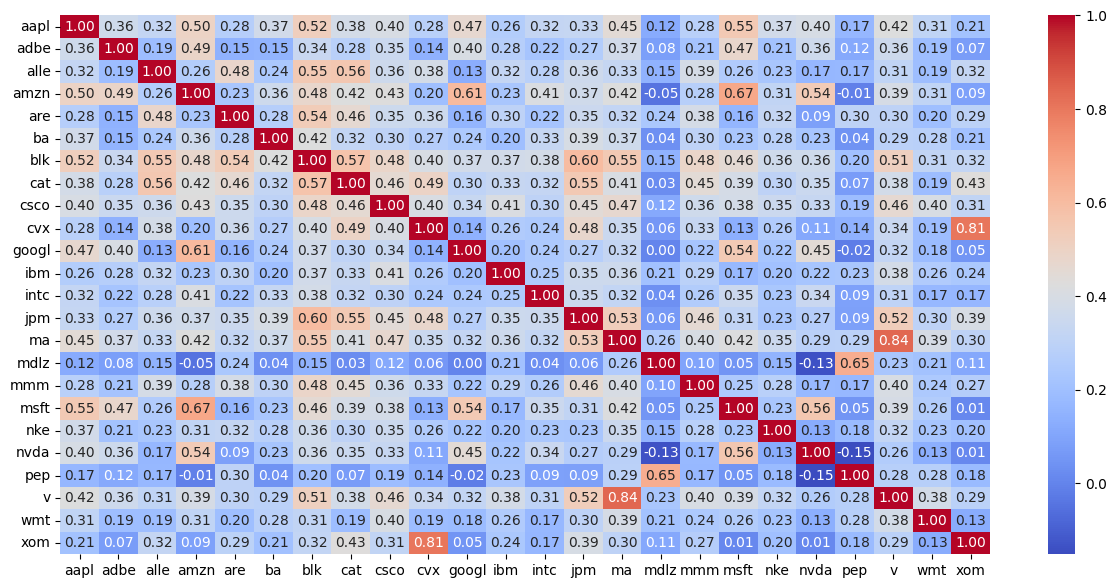

In [10]:
plt.figure(figsize=(15, 7))
sns.heatmap(simple_returns.corr(), annot=True, cmap='coolwarm', fmt='.2f')

In [11]:
# Setting weight for equal distribution among tickers
equal_ws = np.array([1/len(tickers) for _ in tickers])

In [12]:
pfolio_returns = simple_returns.dot(equal_ws)
pfolio_var = np.dot(equal_ws.T, np.dot(simple_returns.cov(), equal_ws))
print(f"Portfolio Returns: {round(pfolio_returns.mean() * 100, 5)} %")
print(f"Portfolio Variance: {pfolio_var}")

Portfolio Returns: 0.06428 %
Portfolio Variance: 0.0001009496620278563


In [13]:
source_daily_path = repo_path + "/data/polygon/daily/"


dividends = pd.DataFrame()

client = RESTClient(api_key)

for ticker in os.listdir(source_daily_path):
    for d in client.list_dividends(
        ticker=ticker,
        order='desc',
        limit=1000,
        sort='ex_dividend_date'
        ):
        dividends = dividends.append({
            'ticker': ticker,
            'ex_dividend_date': d.ex_dividend_date,
            'payment_date': d.payment_date,
            'declared_date': d.declared_date,
            'record_date': d.record_date,
            'amount': d.amount
        }, ignore_index=True)

MaxRetryError: HTTPSConnectionPool(host='api.polygon.io', port=443): Max retries exceeded with url: /v3/reference/dividends?ticker=ba&limit=1000&sort=ex_dividend_date&order=desc (Caused by ResponseError('too many 429 error responses'))